In [21]:
# Notebook setup

library(repr)
options(repr.plot.width=8, repr.plot.height=6)

## Linear Regression

Model:
$$
    y = \beta_0 + \beta_1 x + \epsilon
$$
where $\epsilon \sim N(0, \sigma^2)$.

__Goal: Find the variability in estimates of $\beta$__

In [22]:
# Simulating the model:

b0 = 1
b1 = 5
sigma = 10
n = 10000L

set.seed(37)
x = runif(n)

# SECRET LESSON: Play with the following lines

#epsilon = sigma * rnorm(n)
# But what if it isn't normal?!! GASP!
epsilon = sigma * rt(n, 3)

y = b0 + b1 * x + epsilon

xy = data.frame(x = x, y = y)

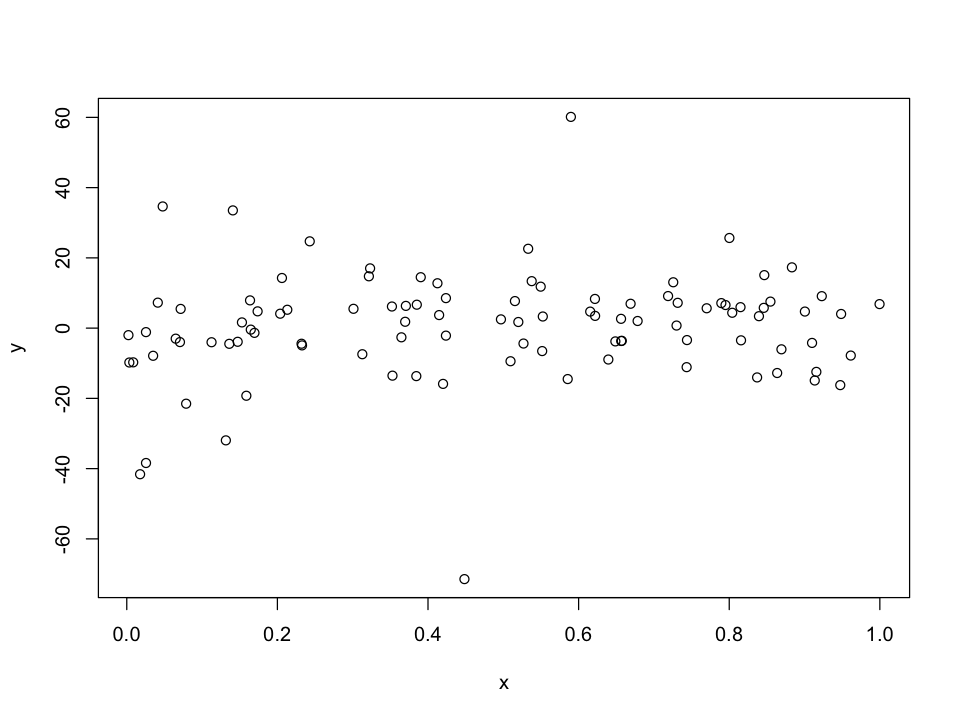

In [23]:
with(xy[1:100, ], plot(x, y))

It's difficult to visually detect the linear relationship because the variance $\sigma^2$ is relatively large.

In [24]:
fit = lm(y ~ x, data = xy)
coef(fit)

(Intercept)           x 
  0.9256451   4.5135066

Since we assumed $\epsilon \sim N(0, \sigma^2)$ we can use a t distribution to calculate exact analytic confidence intervals for the coefficients $\beta_0$ and $\beta_1$. That's what R does here:

In [25]:
confint(fit)

,2.5 %,97.5 %
(Intercept),0.2796422,1.571648
x,3.3922392,5.634774


## Bootstrap

Alternatively, the bootstrap can approximate confidence intervals. The general idea is:
1. Take a sample of size n with replacement of the data
2. Compute the fitted coefficients $\hat{\beta}$.
3. Repeat 1000's of times!

In [26]:
# IMPORTANT: This function takes arguments and does nothing with them.
# And it uses the global variable xy, which MUST be available on the worker machine

# If you think this is weird - you're right!
# We do it here to make something that will easily work in parallel

bootbeta = function(...)
{
    n = nrow(xy)
    xy_boot = xy[sample.int(n, replace = TRUE), ]
    fit_boot = lm(y ~ x, data = xy_boot)
    coef(fit_boot)
}

# Test it!
bootbeta()

(Intercept)           x 
  0.7402433   4.6335976

In [27]:
# We could use replicate()
# doing it this way for consistency with the parallel package
system.time(betas <- lapply(1:1000, bootbeta))

beta_todf = function(betas)
{
    betas = simplify2array(betas)
    row.names(betas) = c("beta0", "beta1")
    betas = data.frame(t(betas)) 
}

betas = beta_todf(betas)

   user  system elapsed 
  8.956   0.026   9.004 

In [28]:
head(betas)

beta0,beta1
1.0345920,3.980326
1.0200276,4.338744
0.6275696,4.863746
0.7279137,4.789514
0.7695179,4.958668
0.3519127,5.788331


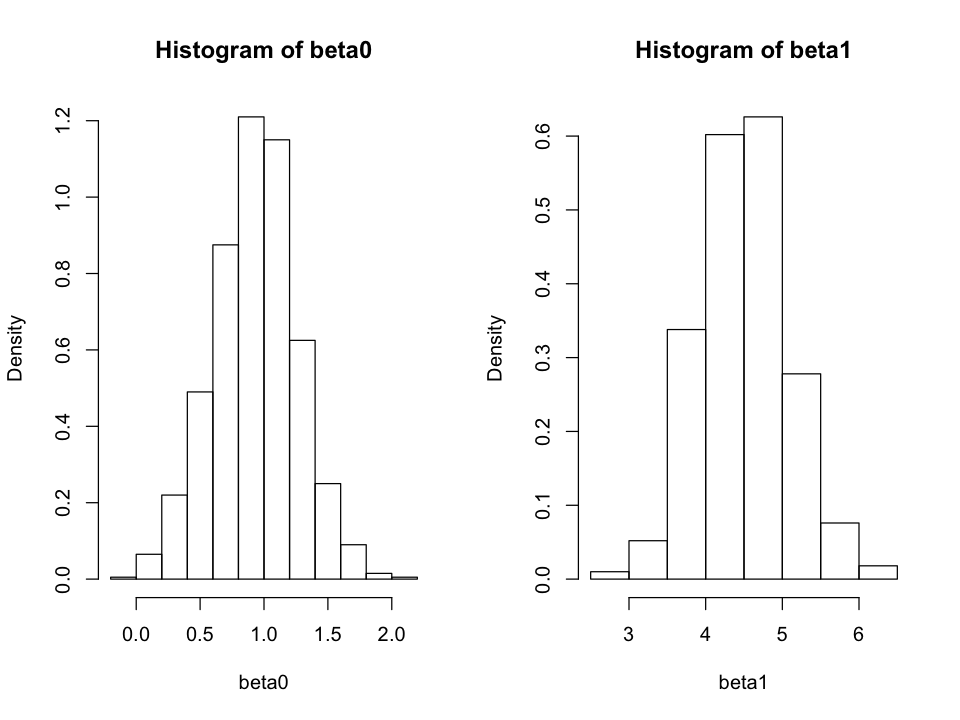

In [29]:
par(mfrow = c(1, 2))
with(betas, hist(beta0, freq = FALSE))
with(betas, hist(beta1, freq = FALSE))

We can take quantiles of the bootstrap statistics to get a 95% confidence interval.

In [30]:
lapply(betas, function(b) quantile(b, probs = c(0.025, 0.975)))

$beta0
     2.5%     97.5% 
0.2608567 1.5561119 

$beta1
    2.5%    97.5% 
3.419527 5.634507

Compare to exact confidence interval from above:

In [31]:
confint(fit)

,2.5 %,97.5 %
(Intercept),0.2796422,1.571648
x,3.3922392,5.634774


# Parallel Time!

What is the embarrassingly parallel problem? Think about it.

In [32]:
library(parallel)

detectCores(logical = FALSE)

[1] 4

`detectCores` is a sanity check. If everything works perfectly then we __may__ see a max speedup of 3.5x for a 4 core machine.

Since I wrote the functions in a nice way above, all I needed to do was change `lapply` to `mclapply`.

Before:
```
system.time(betas <- lapply(1:1000, bootbeta))
```
After:

In [33]:
system.time(betas2 <- mclapply(1:1000, bootbeta))

   user  system elapsed 
  8.635   0.150   4.722 

# MORE SPEED

We do this to accelerate our code. So let's take it a step further and write it in C.

I used to think C was an old language, or too low level so I didn't need to know it. But then I became interested in parallel programming and GPU- C is very much alive.

In [34]:
# Compile the C code into a shared library
# Better to do this from the shell
#system("R CMD SHLIB bootbetas.c")

# Load into R
dyn.load("bootbetas.so")

In [35]:
out = .C("fit_ols", x, y, n, beta = numeric(2))$beta

In [36]:
# Sanity check: This should be numerically 0
out - coef(fit)

(Intercept)             x 
 2.997602e-15 -2.753353e-14

## Side note: did this get us speed?

In [37]:
library(microbenchmark)

lm_c = microbenchmark({.C("fit_ols", x, y, n, beta = numeric(2))$beta})

print(lm_c)

Unit: microseconds
                                                   expr    min      lq     mean
 {     .C("fit_ols", x, y, n, beta = numeric(2))$beta } 35.273 36.6955 72.61542
  median     uq     max neval
 47.7405 84.211 749.527   100


In [38]:
lm_r = microbenchmark({coef(lm(y ~ x))})

print(lm_r)

Unit: milliseconds
                    expr      min       lq     mean   median       uq      max
 {     coef(lm(y ~ x)) } 5.016041 5.256708 6.490141 6.131713 6.260079 35.59846
 neval
   100


R's `lm()` is passed to `lm.fit()` which calls a QR decomposition written in C:
```
.Call(C_Cdqrls, x, y, tol, FALSE)
```

So why is our handwritten C so much faster?

Because the R version is general and robust. This means if you pass it something strange, say with a bunch of NA's, R will gracefully handle it. The C version on the other hand...

In [39]:
# An example of R wrapping C code

bootstrap_c = function(x, y, nboots = 1000L)
{
    n = as.integer(length(x))
    if(n > 32767) stop("That might not work with rand() in C")
    nboots = as.integer(nboots)
    beta = .C("bootstrap"
       , as.numeric(x)
       , as.numeric(y)
       , n
       , nboots
       , beta = numeric(2L * nboots)
      )$beta
    matrix(beta, nrow = 2)
}
    
system.time(betas3 <- bootstrap_c(x, y))

   user  system elapsed 
  0.083   0.000   0.083 

In [40]:
betas3[, 1:10]

0.5335488,0.8297674,1.153499,0.6152166,1.173974,0.8511679,1.087012,0.9014437,1.075177,1.029368
5.1483490,4.2201150,4.194546,4.9309626,4.425706,4.7862344,3.906737,5.0563853,3.840511,4.539016


## Deeper...

The sum of squares in the C code can be parallelized. Hence there are two levels of embarrassing parallelism, and they are nested. So do it on a GPU! 

## Challenge

Take the C code here and modify it into OpenCL which takes advantage of the nested parallelism. Run it on a GPU to see if it's faster.

Tell me if you do this: `clarkfitzg@gmail.com`. I'll buy you lunch.